<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/machine_learning/regression_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine learning resources

courses: 
- http://materias.df.uba.ar/lda2021c1/171-2/
- https://www.kaggle.com/thirty-days-of-ml-assignments
- Coursera 

Tutorials
- https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
- Feature importance: https://machinelearningmastery.com/calculate-feature-importance-with-python/

Books:
- introductory book: Deuschle, WJ (2019). Undergraduate Fundamentals of Machine Learning link here. It's like a basic version of Murphy (see below) 
- Advanced: Murphy, K. P. (2022). Machine learning: a probabilistic perspective. link
James et al (2021). An Introduction to Statistical Learning: with Applications in R (Springer Texts in Statistics)

Other
- Deep dive into evaluation metrics of performance and related analyses:  Varoquaux, G., & Colliot, O. (2022). Evaluating machine learning models and their diagnostic value. link
- Machine learning without programming: https://jasp-stats.org/


# Machine learning tutorial

Data from: Torrente, F., Yoris, A., Low, D., Lopez, P., Bekinschtein, P., Vázquez, G. H., ... & Cetkovich, M. (2022). Psychological symptoms, mental fatigue and behavioural adherence after 72 continuous days of strict lockdown during the COVID-19 pandemic in Argentina. BJPsych open, 8(1).

Data were collected between 21 May 2020 and 4 June 2020 (early pandemic). The survey reached 3617 adults (85.2% female) from all provinces of Argentina after 72 days of lockdown. In that period, Argentina had an Oxford stringency index of 85/100. Of those surveyed, 45.6% met the cut-offs for depression (10 or higher), that is, PHQ-9  levels were much higher than at the start of the pandemic (33.7% [Torrente et al. (2021). J Affect Disord]) and pre-pandemic (5.6%; [Daray et al. (2017). J Affect Disord]) in Argentine samples.

Here we can try to predict a participant's depression score (either ordinal or binary) from their other mental health and demographic data. 

In [60]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [61]:

import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [62]:
# setting to see all columns 
pd.set_option('display.max_columns', None)


# figure size in inches
rcParams['figure.figsize'] = 10,10

# Load data and set input/output paths

In [63]:
from os.path import exists
# config: depends whether you're on Google Colab or local


# Get URL from github csv by clicking on Download > Copy Link Address
# https://github.com/danielmlow/covid19_argentina/blob/main/data/input/Emotional%20symptoms%20COVID19_Arg_May20_v2_text.csv
df = pd.read_csv('https://github.com/danielmlow/covid19_argentina/raw/main/data/input/Emotional%20symptoms%20COVID19_Arg_May20_v2_text.csv')

load_from_google_drive = True

if load_from_google_drive:
  # On google colab
  # Mount GDrive and attach it to the colab for data I/O
  from google.colab import drive
  drive.mount('/content/drive')
  # input_dir = '/content/drive/My Drive/covid19_argentina/data/input/'
  output_dir = '/content/drive/My Drive/covid19_argentina/data/output/'
  os.makedirs(output_dir, exist_ok=True)

else:
  # If using jupyter-lab or jupyter notebook, load locally:
  input_dir = './data/input/'
  output_dir = './data/output/'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

In [64]:
# select subset of variables
df = df[[
        'PHQ9_Total',
        'GAD7_Total',
        'Lockdown_adherence',
        'Age',
        'Gender', #added (binary)
        'Family_Income',  #added (ordinal)
        'Negat_thinking', #added (binary)
        'COGN_DIFFICULTIES_index',
        'Mental_fatigue', 'Threat', 'Riskofcontagion', 
       'Lockdown_difficulty', 'Financialworry_present',
       'Financialworry_future', 'Daily_stress_Index', 'IU_total',
       'UCLA_LS_Total',          
       ]]

In [65]:
# Create dummy variable for categorical variable gender
gender = pd.get_dummies(df['Gender'],prefix='Gender')
print(gender)
print(gender.sum())

gender = pd.get_dummies(gender,prefix='Gender')
df = df.drop('Gender', axis=1)
df['Gender_female'] = gender['Gender_1.0']
# other genders were not included since there were only 9. 


variables = df.columns.values
# df = df.astype(float)




      Gender_1.0  Gender_2.0  Gender_3.0
0              1           0           0
1              0           1           0
2              1           0           0
3              1           0           0
4              1           0           0
...          ...         ...         ...
3612           1           0           0
3613           1           0           0
3614           1           0           0
3615           1           0           0
3616           1           0           0

[3617 rows x 3 columns]
Gender_1.0    3083
Gender_2.0     525
Gender_3.0       9
dtype: int64


In [66]:
# Provide clean names for manuscript table
print(variables)

# Use cleaner names in the final table

clean_names= dict(zip(
    variables,
    ['PHQ9', 'GAD7','Lockdown adherence','Age','Family income', 'Negative thinking','Cognitive troubles', 'Mental fatigue', 'Perceived threat', 'Perceived risk','Lockdown difficulty','Financial worries (present)','Financial worries (future)','Daily stress', 'Intolerance of uncertainty', 'Loneliness scale', 'Female', 'Male']
    
    ))

clean_names

['PHQ9_Total' 'GAD7_Total' 'Lockdown_adherence' 'Age' 'Family_Income'
 'Negat_thinking' 'COGN_DIFFICULTIES_index' 'Mental_fatigue' 'Threat'
 'Riskofcontagion' 'Lockdown_difficulty' 'Financialworry_present'
 'Financialworry_future' 'Daily_stress_Index' 'IU_total' 'UCLA_LS_Total'
 'Gender_female']


{'PHQ9_Total': 'PHQ9',
 'GAD7_Total': 'GAD7',
 'Lockdown_adherence': 'Lockdown adherence',
 'Age': 'Age',
 'Family_Income': 'Family income',
 'Negat_thinking': 'Negative thinking',
 'COGN_DIFFICULTIES_index': 'Cognitive troubles',
 'Mental_fatigue': 'Mental fatigue',
 'Threat': 'Perceived threat',
 'Riskofcontagion': 'Perceived risk',
 'Lockdown_difficulty': 'Lockdown difficulty',
 'Financialworry_present': 'Financial worries (present)',
 'Financialworry_future': 'Financial worries (future)',
 'Daily_stress_Index': 'Daily stress',
 'IU_total': 'Intolerance of uncertainty',
 'UCLA_LS_Total': 'Loneliness scale',
 'Gender_female': 'Female'}

# Descriptive statistics

In [67]:
df.columns

Index(['PHQ9_Total', 'GAD7_Total', 'Lockdown_adherence', 'Age',
       'Family_Income', 'Negat_thinking', 'COGN_DIFFICULTIES_index',
       'Mental_fatigue', 'Threat', 'Riskofcontagion', 'Lockdown_difficulty',
       'Financialworry_present', 'Financialworry_future', 'Daily_stress_Index',
       'IU_total', 'UCLA_LS_Total', 'Gender_female'],
      dtype='object')

In [68]:
# Observe the descriptive stats of the independent variables
df.drop('PHQ9_Total',axis=1).describe()

,GAD7_Total,Lockdown_adherence,Age,Family_Income,Negat_thinking,COGN_DIFFICULTIES_index,Mental_fatigue,Threat,Riskofcontagion,Lockdown_difficulty,Financialworry_present,Financialworry_future,Daily_stress_Index,IU_total,UCLA_LS_Total,Gender_female
count,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,7.033177,8.441803,47.310755,1.840752,0.735693,2.969035,10.442908,6.617639,5.447885,5.279513,6.909594,5.864805,0.425491,31.962123,8.664086,0.852364
std,5.171025,1.831086,12.765485,0.775430,0.441025,2.189863,4.095191,2.417796,2.502014,2.908373,2.455660,2.402000,2.930999,10.754010,6.675201,0.354788
min,0.000000,1.000000,18.000000,1.000000,0.000000,0.000000,5.000000,1.000000,0.000000,1.000000,1.000000,1.000000,-8.000000,12.000000,0.000000,0.000000
25%,3.000000,8.000000,38.000000,1.000000,0.000000,1.000000,8.000000,5.000000,4.000000,3.000000,5.000000,4.000000,-2.000000,24.000000,3.000000,1.000000
50%,6.000000,9.000000,46.000000,2.000000,1.000000,3.000000,10.000000,7.000000,5.000000,5.000000,7.000000,6.000000,0.000000,31.000000,8.000000,1.000000
75%,10.000000,10.000000,56.000000,2.000000,1.000000,5.000000,12.000000,8.000000,7.000000,8.000000,9.000000,8.000000,2.000000,39.000000,13.000000,1.000000
max,21.000000,10.000000,95.000000,3.000000,1.000000,7.000000,25.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,60.000000,30.000000,1.000000


### Take a subsample of observations and variables for faster plotting

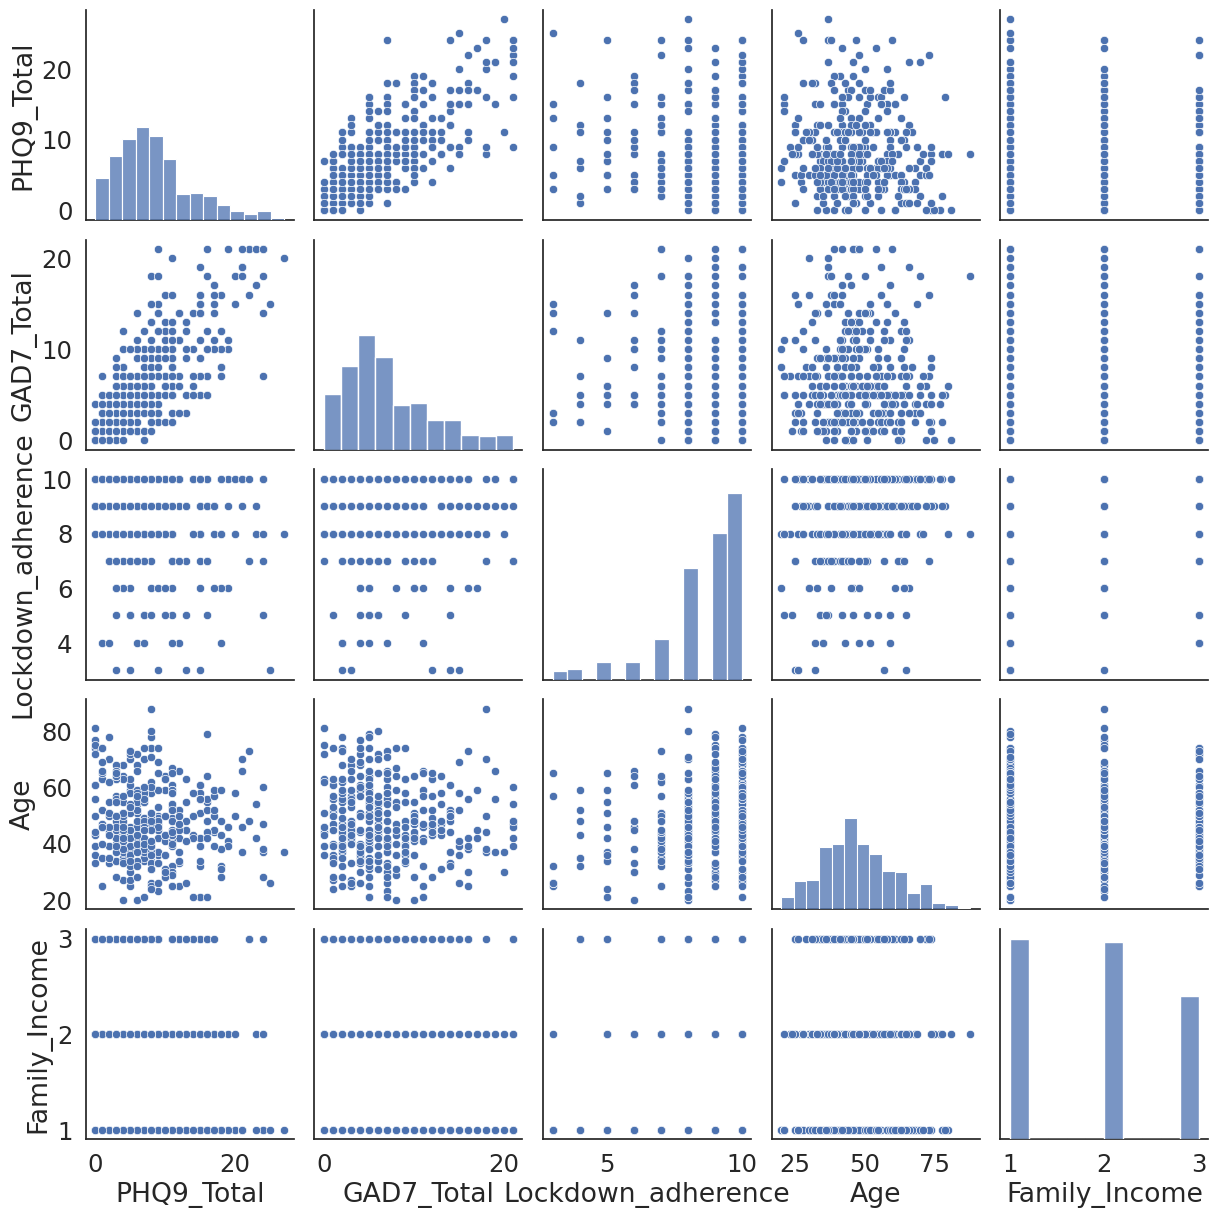

In [69]:
subsample = 0.1 # 0.1=10% of data, 1 = 100%
variables_to_plot = ['PHQ9_Total', 'GAD7_Total', 'Lockdown_adherence', 'Age',
       'Family_Income'] # It 
df_subsample = df[variables_to_plot].sample(frac=subsample)
sns.pairplot(df_subsample)
plt.show()

### More thorough stats

NameError: ignored

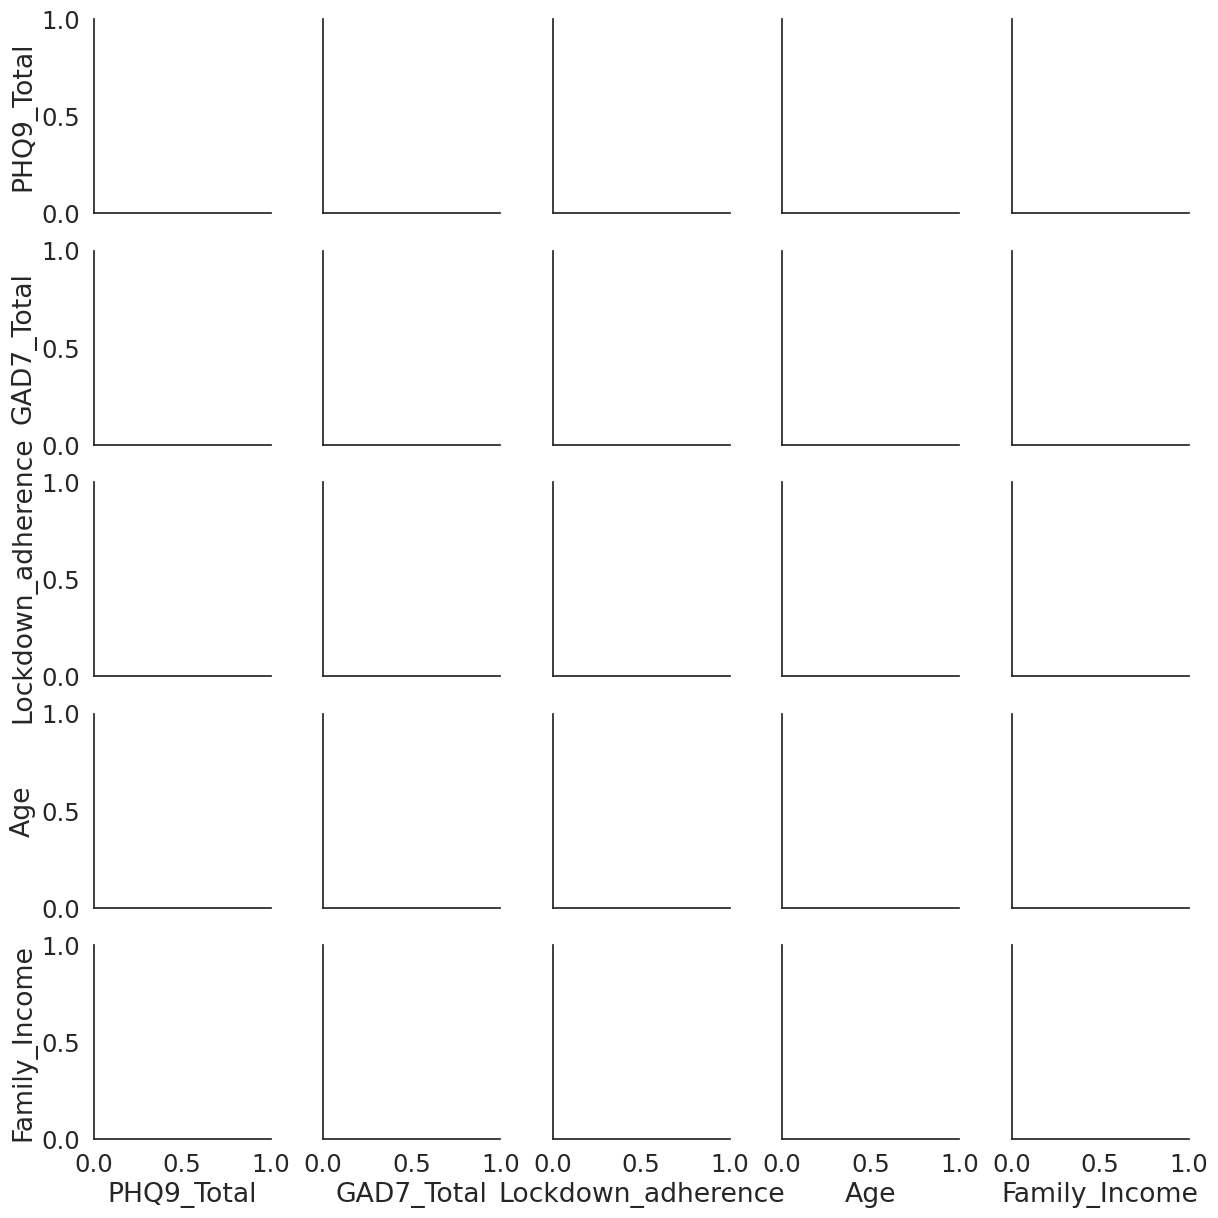

In [70]:

def reg_coef(x,y,label=None,color=None, **kwargs):
    ax = plt.gca()
    r,p = spearmanr(x,y)
    if p < 0.01:
        sig_level = '***'
    elif p < 0.05:
        sig_level = '**'
    elif p < 0.05:
        sig_level = '*'
    else:
        sig_level = ''
        
    ax.annotate('r = {:.2f} {}'.format(r, sig_level), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.texts[0].set_size(16)
    ax.set_axis_off()

# Create the plot
g = sns.PairGrid(data=df_subsample, vars=df_subsample.columns, hue=None)
g.map_upper(reg_coef)
g = g.map_lower(sns.regplot, scatter_kws={"edgecolor": "white"})
g = g.map_diag(sns.histplot, kde=True)
plt.show()

In [ ]:

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.75, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40 #abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    

# Pairwise correlation plot
sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
g = sns.PairGrid(df_subsample, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'black'}, fit_reg=True,
          x_jitter=.1, y_jitter=.1, 
            scatter_kws={"s": 1, "alpha":0.1}
            )
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

# Create DFs for each independent variable

In [ ]:
def add_top_column(df, top_col, inplace=True):
    if not inplace:
        df = df.copy()
    
    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

In [ ]:


# Depression

variables_depression = df.drop('PHQ9_Total',axis=1).columns.values
X_depression = df.drop('PHQ9_Total',axis=1).values
y_depression = df['PHQ9_Total'].values
print('depression independent variables', variables_depression)
print(X_depression.shape, y_depression.shape)
print('\n\n')

# Anxiety

variables_anxiety = df.drop('GAD7_Total',axis=1).columns.values
X_anxiety = df.drop('GAD7_Total',axis=1).values
y_anxiety = df['GAD7_Total'].values
print('Anxiety independent variables', variables_anxiety)
print(X_anxiety.shape, y_anxiety.shape)
print('\n\n')


# Lockdown Adherence

variables_lockdown = df.drop('Lockdown_adherence',axis=1).columns.values
X_lockdown = df.drop('Lockdown_adherence',axis=1).values
y_lockdown = df['Lockdown_adherence'].values
print('Lockdown Adherence independent variables', variables_lockdown)
print(X_lockdown.shape, y_lockdown.shape)
print('\n\n')



# Model evaluation

We're going to fit LASSO models and optimize the alpha or L1 parameter (regularization strength).

### Hyperparameter tuning on training set

In [82]:
plt.rcParams["figure.figsize"] = (6,6)

In [83]:


# Parameters of pipelines can be set using ‘__’ separated parameter names:

def lasso_standardscaler_alpha(X,y,cv=10):
    alphas= np.logspace(-4, 0, 30) #equally spaced on log scale from 10**-4 (0.0004) to 10**0 (1)
    
    # Pipeline: https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('model', Lasso())
    ])
    
    # hyperparameters and their values we're testing through gridsearch
    param_grid = {
        'model__alpha': alphas,
    }
    search = GridSearchCV(pipe,param_grid, cv=cv,n_jobs=-1) # perfrom k-fold CV on the training set

    search.fit(X,y) # Train model
    results = pd.DataFrame(search.cv_results_)
    # display(results)
    best = results[results['rank_test_score']==1] #best hyperparameters
    mean_score = best.mean_test_score.values
    std_score = best.std_test_score.values
    alpha = float(best.param_model__alpha.values)
    return alpha

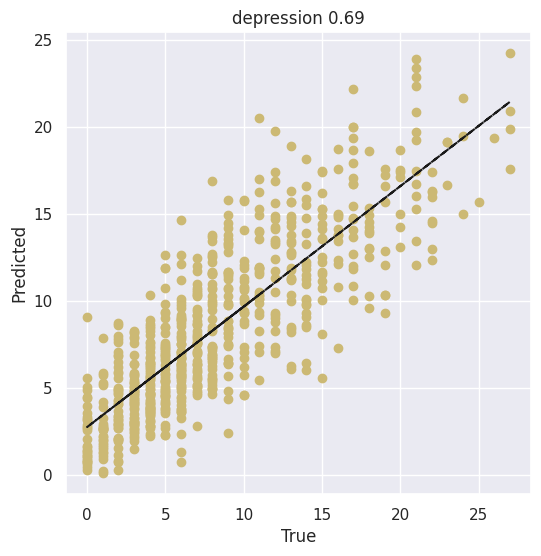

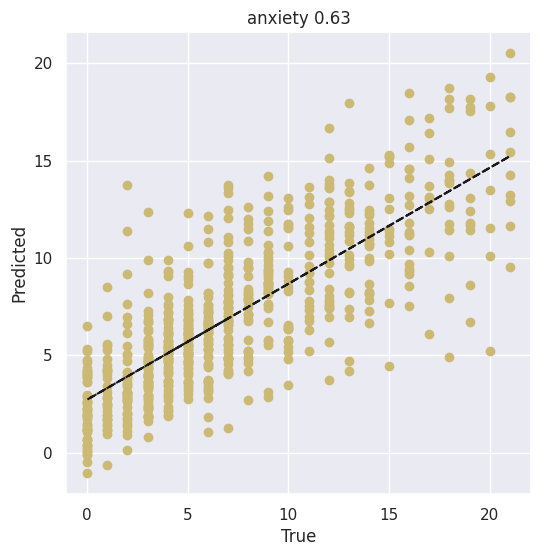

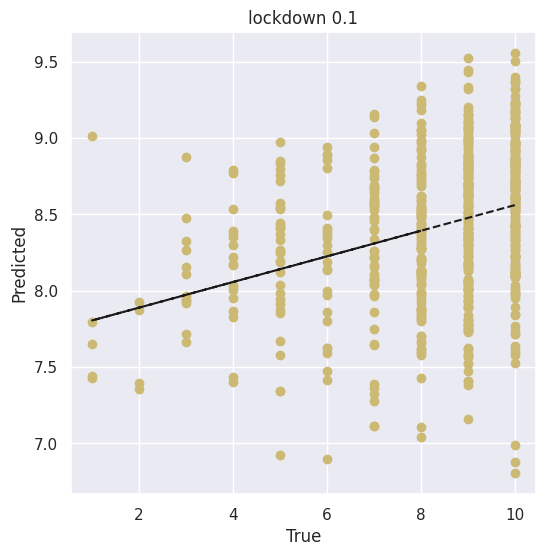

In [84]:
# Train and test

coefs_all= []
r2_all=[]
y_pred_all = {}

for X_i,y_i,variables,name in [
    [X_depression, y_depression, variables_depression,'depression'],
    [X_anxiety, y_anxiety, variables_anxiety,'anxiety'],
    [X_lockdown, y_lockdown,  variables_lockdown,'lockdown'],
                            ]:
    #80-20 Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_i, y_i, test_size=0.2, random_state=42)

    # Hyperparameter tuning     
    best_alpha = lasso_standardscaler_alpha(X_train,y_train,cv=10) # Find best alpha through CV
    
    # Train final model      
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()), 
        ('model', Lasso(alpha = best_alpha))
    ])
    pipe.fit(X_train,y_train)
    
    # Test     
    y_pred = pipe.predict(X_test)
    r2 = r2_score(y_test,y_pred)
    y_pred_all[name]=y_pred
    
    # Obtain standardized beta coefficients     
    coefs= pd.DataFrame(pipe['model'].coef_,index=variables, columns= ['Coef.'])
    
    # Clean dataframe     
    coefs.index = [clean_names.get(n) for n in coefs.index.values]
    coefs['Abs. Coef.'] = coefs['Coef.'].abs()
    coefs= coefs.sort_values('Abs. Coef.')[::-1].reset_index()
    coefs.index +=1
    coefs= coefs.reset_index().round(2)
    coefs.columns= ['Importance', 'Covariate', 'Coef.','Abs. Coef.']
    coefs['Coef.'] =     coefs['Coef.'].astype(str).replace('^(-)0.|^0.',r'\1.',regex=True)
    if name == 'depression':
        coefs= coefs.drop(['Abs. Coef.'], axis=1)#drop abs value
    else:
        coefs= coefs.drop(['Abs. Coef.','Importance'], axis=1)#drop abs value
    
    coefs = add_top_column(coefs,f'{name.capitalize()} R^2 = {np.round(r2,2)}' )
    coefs.to_csv(output_dir+f'coefs_{name}.csv',index=False)
    coefs_all.append(coefs)
    r2_all.append([name,np.round(r2,2)])
    
    #Plot predictions vs true
    
    coef = np.polyfit(y_test,y_pred,1)
    poly1d_fn = np.poly1d(coef) 
    # poly1d_fn is now a function which takes in x and returns an estimate for y
    plt.plot(y_test,y_pred, 'yo', y_test, poly1d_fn(y_test), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'{name} {np.round(r2,2)}')
    plt.show()



In [85]:
# Concatenate 3 dataframes
coefs_all_clean = pd.concat(coefs_all,axis=1)
coefs_all_clean.to_csv(output_dir+'coefs_all.csv', index=False) 
coefs_all_clean

Depression R^2 = 0.69                                     \
              Importance                    Covariate Coef.   
0                      1                         GAD7  2.57   
1                      2               Mental fatigue  1.53   
2                      3           Cognitive troubles   .68   
3                      4             Loneliness scale   .49   
4                      5                 Daily stress  -.29   
5                      6          Lockdown difficulty   .22   
6                      7  Financial worries (present)  -.17   
7                      8                Family income  -.15   
8                      9   Intolerance of uncertainty   .14   
9                     10                          Age  -.12   
10                    11                       Female    .1   
11                    12            Negative thinking   .08   
12                    13   Financial worries (future)  -.02   
13                    14               Perceived risk    .0   
14                    15             Perceived threat   -.0   
15                    16           Lockdown adherence   -.0   

             Anxiety R^2 = 0.63                 Lockdown R^2 = 0.1        
                      Covariate Coef.                    Covariate Coef.  
0                          PHQ9  2.62             Perceived threat   .39  
1    Intolerance of uncertainty   .83                       Female   .12  
2           Lockdown difficulty   .48  Financial worries (present)    .1  
3            Cognitive troubles   .32               Perceived risk   .09  
4              Loneliness scale   .31            Negative thinking  -.08  
5                 Family income   .29   Intolerance of uncertainty   .08  
6             Negative thinking   .29           Cognitive troubles  -.07  
7                  Daily stress  -.21                 Daily stress   .05  
8   Financial worries (present)  -.19                Family income   .05  
9    Financial worries (future)  -.19                         GAD7  -.05  
10               Perceived risk   .13                          Age  -.02  
11                       Female   .12                         PHQ9  -.02  
12               Mental fatigue    .1             Loneliness scale   -.0  
13                          Age  -.07   Financial worries (future)    .0  
14           Lockdown adherence  -.06          Lockdown difficulty   -.0  
15             Perceived threat   .01               Mental fatigue   -.0

# Classification

In [141]:
plt.rcParams["figure.figsize"] = (4,4)

In [151]:
import random
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import f1_score, roc_auc_score
from matplotlib.pyplot import figure
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

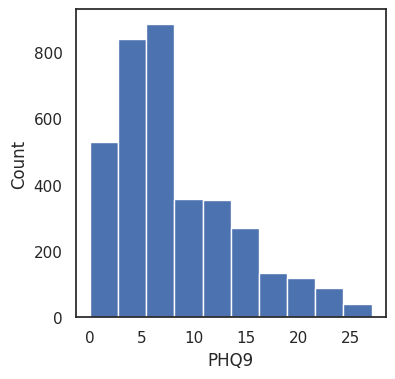

In [143]:
y_depression
# plt.figure(figsize=(4,4))
plt.hist(y_depression)
plt.xlabel('PHQ9')
plt.ylabel('Count')
plt.show()

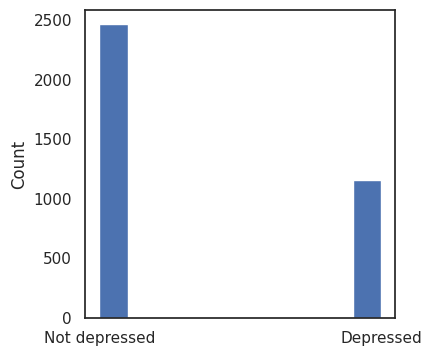

In [144]:
y_depression_binary = []
for i in y_depression:
  if i >= 10:
    y_depression_binary.append(1)
  else:
    y_depression_binary.append(0)

y_depression_binary = np.array(y_depression_binary)
plt.hist(y_depression_binary)
plt.xticks(ticks = [0,1], labels = ['Not depressed', 'Depressed'])
plt.ylabel('Count')
plt.show()

In [145]:
Counter(y_depression_binary)

Counter({0: 2463, 1: 1154})

In [146]:
params_grid = [
              {
                'estimator':[LogisticRegression()],
                'estimator__penalty': ['l1', 'l2'],
                },
                {
                'estimator':[SVC(probability=True)],
                'estimator__C': [0.1, 1, 10],
                 'estimator__kernel': ['linear', 'rbf'],
                },
               # For the ROC AUC below, we need to output the probabilities, not sure 
                # {
                # 'estimator': [RandomForestClassifier()],
                # 'estimator__n_estimators': [50, 250],
                # 'estimator__max_depth': [3,10],
                # },
               ]

In [147]:
len(X_depression)

3617

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.71994115 0.70514977 0.67346401 0.70915038 0.72632771
 0.70915038 0.68485954]
  warnings.warn(


=====
best parameters {'estimator': SVC(C=1, probability=True), 'estimator__C': 1, 'estimator__kernel': 'rbf'}
=====
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       143
           1       0.77      0.81      0.79        57

    accuracy                           0.88       200
   macro avg       0.84      0.85      0.85       200
weighted avg       0.88      0.88      0.88       200

CPU times: user 965 ms, sys: 12.2 ms, total: 978 ms
Wall time: 5.91 s


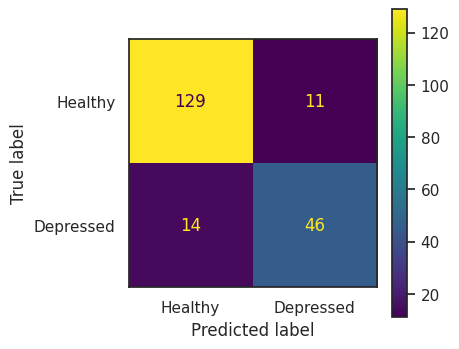

In [148]:
%%time
toy = True

if toy:
  # use a subsample
  m = 1000
  X_depression_toy, y_depression_binary_toy = zip(*random.sample(list(zip(X_depression, y_depression_binary)), m))
  X_train, X_test, y_train, y_test = train_test_split(X_depression_toy, y_depression_binary_toy, test_size=0.2, random_state=42)
else:
  X_train, X_test, y_train, y_test = train_test_split(X_depression, y_depression_binary, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('normalize', StandardScaler()),
    ('estimator', LogisticRegression())
    ])#initialize with any classifier, but then it will test all estimators specified in params_grid

# Train the grid search model
gs = GridSearchCV(pipeline, params_grid, cv=5, n_jobs=-1, scoring='f1').fit(X_train, y_train) # I use f1-score because it is less affected by class imbalance
# Best performing model and its corresponding hyperparameters
print('=====')
print('best parameters', gs.best_params_)
print('=====')

# Test data performance
y_pred = gs.predict(X_test)
print(classification_report(y_pred, y_test))
cm = confusion_matrix(y_test, y_pred, )

cm_display = ConfusionMatrixDisplay(cm, display_labels = ['Healthy', 'Depressed']).plot()
plt.grid(False)


### ROC AUC curve


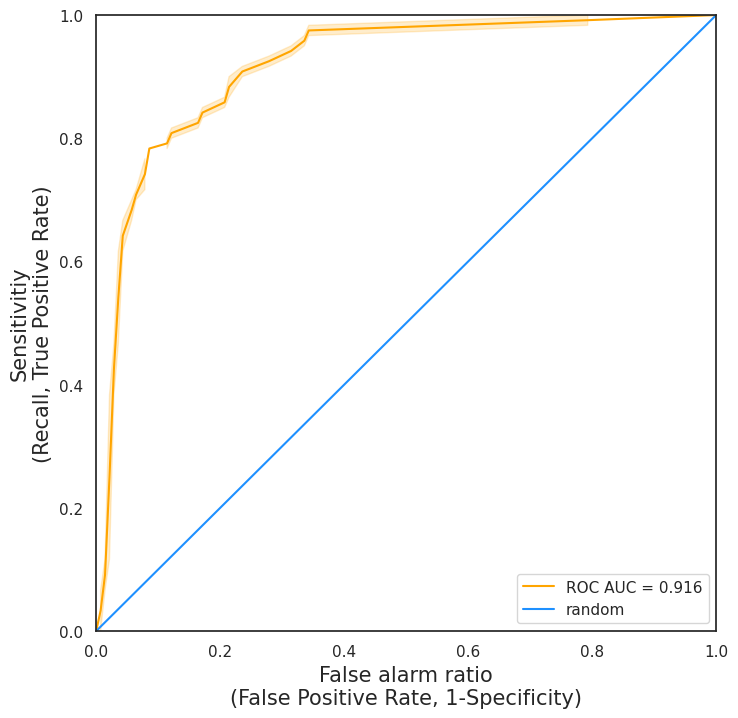

Important
Notice that if you compute roc_auc score without the probabilities, you get an incorrect estimate
0.844047619047619


In [152]:
import sklearn.metrics as metrics
from scipy.special import softmax

# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test)
# preds = probs[:,1]

# Softmax. not really making sense.
# https://discuss.pytorch.org/t/logits-vs-log-softmax/95979

predictions = gs.predict_proba(X_test)

predictions_softmax = softmax(predictions, axis=1)
np.set_printoptions(suppress=True)
y_probs = predictions_softmax[:,1] #softmax in case model does not output prob distributio. prediction for class=1

fpr, tpr, threshold = metrics.roc_curve(y_test,y_probs)
roc_auc = metrics.auc(fpr, tpr)
plt.clf()
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style("white")

size = 15
# plt.title('Receiver Operating Characteristic')
sns.lineplot(x = fpr, y = tpr, label = f'ROC AUC = {np.round(roc_auc,3)}', color='orange')
plt.legend(loc = 'lower right', fontsize=size+10)
sns.lineplot(x = [0, 1], y = [0, 1],markers='--', label = 'random', color='dodgerblue')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Sensitivitiy\n(Recall, True Positive Rate)', size=size)
plt.xlabel('False alarm ratio\n(False Positive Rate, 1-Specificity)',size=size)
# plt.savefig(output_dir+f'roc_auc_curve_{ts}.png', dpi=300)
plt.show()


print('Important')
print('Notice that if you compute roc_auc score without the probabilities, you get an incorrect estimate')
print(roc_auc_score(y_test,y_pred)) # instead of y_probs



### Precision-recall curve (when there is class imbalance like in this case, ROC AUC is biased and too high)

In [156]:
y_test = np.array(y_test)
y_test[y_test==1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Logistic: f1=0.786 P-R auc=0.767


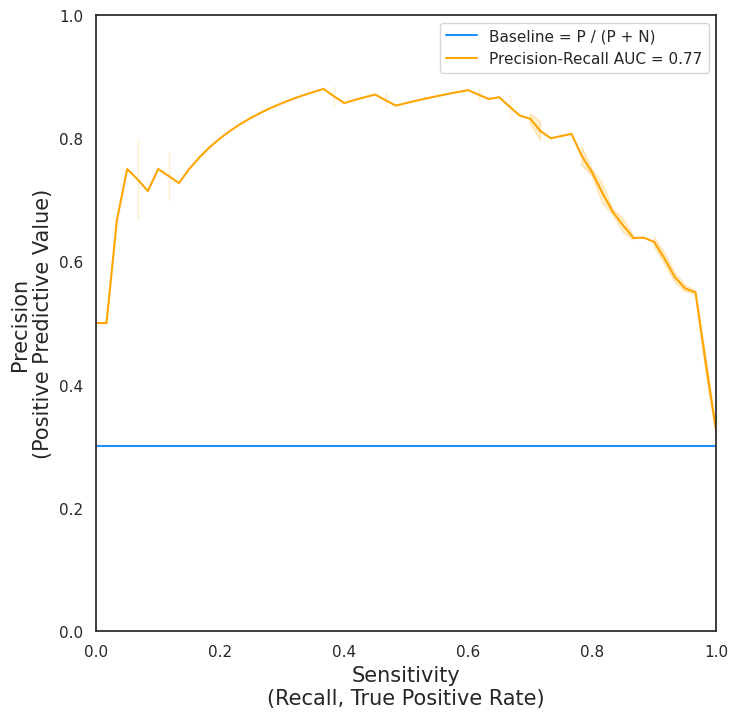

In [160]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

plt.clf()
sns.set(rc={'figure.figsize':(8,8)})
sns.set_style("white")

# calculate precision and recall for each threshold
precision, recall, _ = precision_recall_curve(y_test, y_probs)
# calculate scores
f1  = f1_score(y_test, y_pred)
pr_auc = auc(recall, precision)
# summarize scores
print('Logistic: f1=%.3f P-R auc=%.3f' % (f1, pr_auc))
# plot the precision-recall curves
y_test = np.array(y_test)
baseline = len(y_test[y_test==1]) / len(y_test)  #  baseline of PRC is determined by the ratio of positives (P) and negatives (N) as y = P / (P + N)
sns.lineplot(x=[0, 1], y=[baseline, baseline], markers='--', label='Baseline = P / (P + N)', color='dodgerblue')
sns.lineplot(x=recall, y=precision,label=f'Precision-Recall AUC = {np.round(pr_auc,2)}',color='orange' )#, marker='.', )
# axis labels
plt.xlabel('Sensitivity\n(Recall, True Positive Rate)',size=size)
plt.ylabel('Precision\n(Positive Predictive Value)',size=size)
plt.legend()

plt.xlim([0, 1])
plt.ylim([0, 1])
# plt.savefig(output_dir+f'precision_recall_curve_{ts}.png', dpi=300)
plt.show()

### Classification permutation import

<Figure size 3600x2400 with 0 Axes>

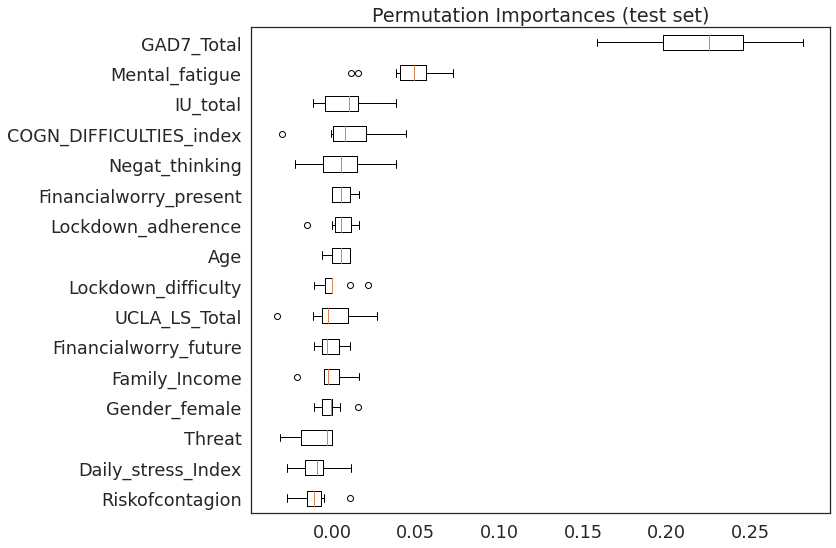

In [ ]:


result = permutation_importance(gs, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=-1)

figure(figsize=(12,8), dpi=300)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=variables_depression[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Extensions
- feature importance: permutation importance, LOFO
- Generalized Additive Model
- Speech, vision data
- RandomizedSearchCV instead of GridSearchCV
- autoML and auto sklearn
- nested cross-validation for hyperparameter tuning
- repeated measures
  - group shuffle split
  - time series cross-validation 